<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_SE_CPMG_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypulseq &> /dev/null
!pip install  torchkbnufft --no-deps
!pip install MRzeroCore --no-deps
!pip install pydisseqt
!pip install ismrmrd

!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

(SE_CPMG_seq)=
# Spin Echo - CPMG

In [2]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
def seq_CPMG(
    fov=(220e-3, 220e-3, 8e-3),
    Nread=96,
    Nphase=96,
    Npart=1,
    FA=None,     # excitation flip angle tensor
    FA_ref=None, # refocusing flip angle tensor
    TE=None,     # echo time tensor
    etl=None,    # echo train length
    slice_thickness=8e-3,
    bw=None,     # bandwidth
    experiment_id="CPMG",
    system=None,
):
    """
    Generate a CPMG (Carr-Purcell-Meiboom-Gill) sequence following the MRzero standard.
    
    Args:
        fov: tuple of floats (x, y, z) in meters
        Nread: int - frequency encoding steps
        Nphase: int - phase encoding steps
        Npart: int - number of partitions
        FA: tensor - excitation flip angle
        FA_ref: tensor - refocusing flip angle
        shim: tensor - shim values
        TR: tensor - repetition time
        TE: tensor - echo time
        etl: int - echo train length
        slice_thickness: float - slice thickness in meters
        bw: int - bandwidth
        experiment_id: string - experiment identifier
        system: optional scanner system limits
    
    Returns:
        pp.Sequence: Pulseq sequence object
    """
    
    # Use default system if none provided
    if system is None:
        system = pp.Opts(
            max_grad=28, grad_unit='mT/m',
            max_slew=150, slew_unit='T/m/s',
            rf_ringdown_time=20e-6,
            rf_dead_time=100e-6,
            adc_dead_time=20e-6,
            grad_raster_time=10e-6
        )
    
    # Create sequence
    seq = pp.Sequence()
    
    # Set sequence definitions according to standard
    seq.set_definition('name', experiment_id)
    seq.set_definition('fov', [fov[0], fov[1], fov[2]])
    seq.set_definition('matrix', [Nread, Nphase, Npart])
    
    # Extract parameters
    fov_x, fov_y, slice_thickness = fov
    
    # Use provided FA or default
    if FA is not None:
        flip_angle_ex = FA.item() if hasattr(FA, 'item') else FA
    else:
        flip_angle_ex = 90 * np.pi / 180  # default 90 degrees
        
    if FA_ref is not None:
        flip_angle_ref = FA_ref.item() if hasattr(FA_ref, 'item') else FA_ref
    else:
        flip_angle_ref = 180 * np.pi / 180  # default 180 degrees
    
    # Use provided TE or default
    if TE is not None:
        TE_val = TE.item() if hasattr(TE, 'item') else TE
    else:
        TE_val = 1e-3  # default 1 ms
        
    # Use provided ETL or default
    if etl is None:
        etl = 12  # default
    
    # Calculate dwell time based on bandwidth if provided
    if bw is not None:
        dwell_time = 1 / bw
    else:
        dwell_time = 1e-4  # default
    
    # Define rf events
    rf1, _, _ = pp.make_sinc_pulse(
        flip_angle=flip_angle_ex,
        duration=1e-3,
        slice_thickness=slice_thickness,
        apodization=0.5,
        time_bw_product=4,
        delay=0,
        system=system,
        return_gz=True
    )
    
    rf2, _, _ = pp.make_sinc_pulse(
        flip_angle=flip_angle_ref,
        duration=1e-3,
        phase_offset=90 * np.pi / 180,
        slice_thickness=slice_thickness,
        apodization=0.5,
        time_bw_product=4,
        system=system,
        return_gz=True
    )
    
    sym_rf_block_delay = pp.calc_duration(rf1) - rf1.ringdown_time + rf1.delay
    
    # Define other gradients and ADC events
    adc = pp.make_adc(
        num_samples=Nread,
        duration=Nread * dwell_time,
        phase_offset=0,
        system=system
    )
    
    minTE = pp.calc_duration(adc) + sym_rf_block_delay
    
    print(f"Minimum TE: {minTE*1000:.2f} ms")
    
    TEdelay = (TE_val - minTE) / 2
    if TEdelay < 0:
        TEdelay = 0
    
    
    # ======
    # CONSTRUCT SEQUENCE
    # ======
    seq.add_block(rf1, sym_rf_block_delay)
    seq.add_block(pp.make_delay(TEdelay + minTE/2 - sym_rf_block_delay))
    
    for i in range(0, etl):
        seq.add_block(rf2, sym_rf_block_delay)
        seq.add_block(pp.make_delay(TEdelay))
        seq.add_block(adc)
        seq.add_block(pp.make_delay(TEdelay))
    
    seq.write(experiment_id + ".seq")
    return seq

C:\Users\alyar\AppData\Local\Temp\ipykernel_8180\2571872106.py:88: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf1, _, _ = pp.make_sinc_pulse(
C:\Users\alyar\AppData\Local\Temp\ipykernel_8180\2571872106.py:99: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf2, _, _ = pp.make_sinc_pulse(
C:\Users\alyar\AppData\Local\Temp\ipykernel_8180\2571872106.py:113: UserWarning: Specified ADC delay 0.00 us is less than the dead time 20 us. Delay was increased to the dead time.
  adc = pp.make_adc(


Minimum TE: 4.34 ms
DEPRECATED: util.simulate_2d will be removed in the future.
Use util.simulate() instead (together with util.load_phantom() if necessary
Calculating repetition 13 / 13 - done


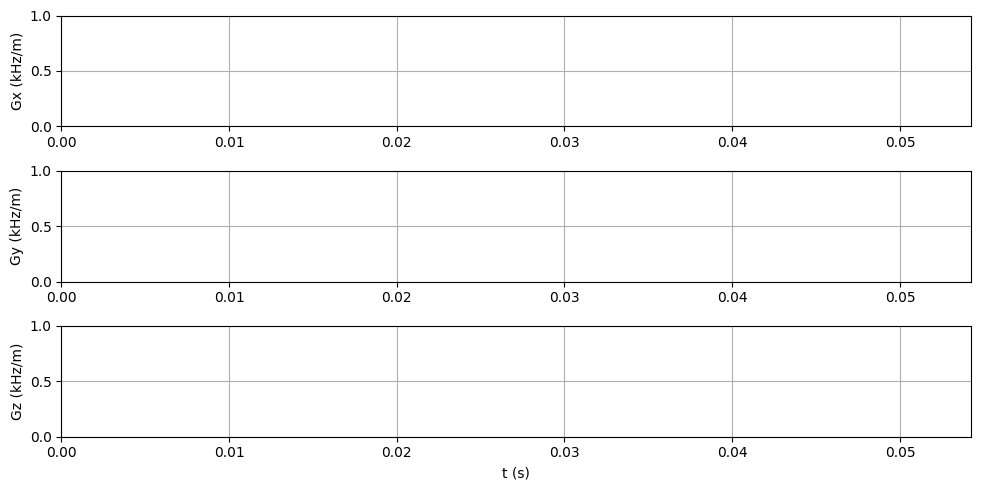

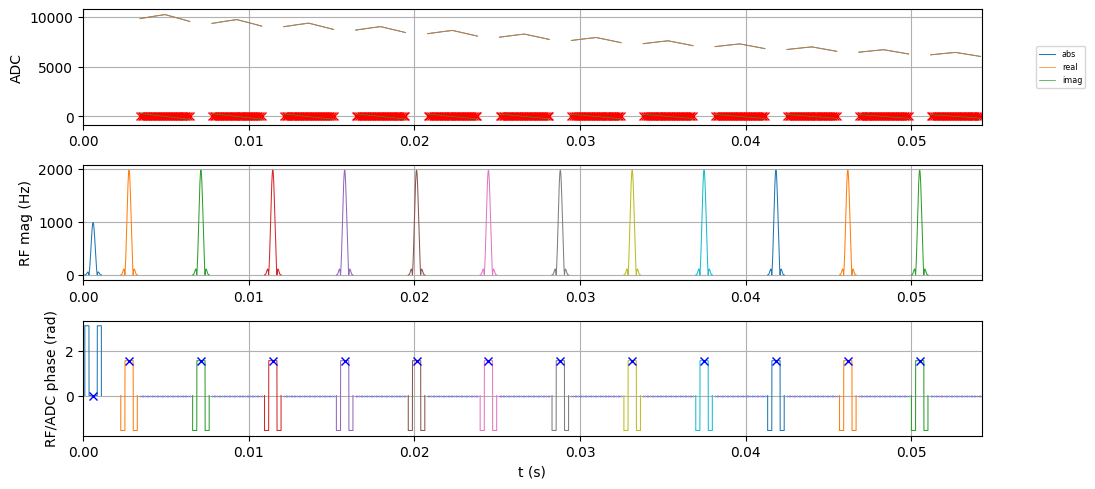

In [4]:
# Define parameters as plain variables
fov = (200e-3, 200e-3, 8e-3)
Nread = 31  #@param {type:"slider", min:0, max:512, step:1}
Nphase = 1
FA_deg = 90
refocusing_angle = 180  #@param {type:"slider", min:0, max:360, step:1}
TE_ms = 1  #@param {type:"slider", min:1, max:100, step:1}
etl = 12  #@param {type:"slider", min:1, max:32, step:1}

# Generate sequence using standard parameters
seq = seq_CPMG(
    fov=fov,
    Nread=Nread,
    Nphase=Nphase,
    FA=torch.tensor(FA_deg * np.pi / 180),
    FA_ref=torch.tensor(refocusing_angle * np.pi / 180),
    TE=torch.tensor(TE_ms * 1e-3),
    etl=etl,
)

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
#quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)

seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal=signal.numpy())
plt.show()

In [5]:
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

Timing check passed successfully
